# Quenching and drifting examples
In this notebook we apply the quenching and drifting stages to a track dataset

In [1]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from larndsim import consts
consts.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                                "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

from larndsim import quenching, drifting
from larndsim import quenching_ep, drifting_ep
import importlib
importlib.reload(drifting)
importlib.reload(quenching)
importlib.reload(drifting_ep)
importlib.reload(quenching_ep)

from math import ceil

import matplotlib.pyplot as plt

import numpy as np
import h5py

from numpy.lib import recfunctions as rfn
import torch

def torch_from_structured(tracks):
    tracks_np = rfn.structured_to_unstructured(tracks, copy=True, dtype=np.float32)
    return torch.from_numpy(tracks_np).float()

def structered_from_torch(tracks_torch, dtype):
    return rfn.unstructured_to_structured(tracks_torch.cpu().numpy(), dtype=dtype)

In [3]:
with h5py.File('edepsim_1M.h5', 'r') as f:
    tracks = np.array(f['segments'])

y_start = np.copy(tracks['y_start'] )
y_end = np.copy(tracks['y_end'])
y = np.copy(tracks['y'])

tracks['y_start'] = np.copy(tracks['z_start'])
tracks['y_end'] = np.copy(tracks['z_end'])
tracks['y'] = np.copy(tracks['z'])

tracks['z_start'] = y_start
tracks['z_end'] = y_end
tracks['z'] = y

# tracks = tracks[:1000]

In [4]:
tracks_box = np.copy(tracks)
tracks_birks = np.copy(tracks)
print(tracks_box.shape)
print(tracks_birks.shape)

(154359,)
(154359,)


In [5]:
threadsperblock = 256
blockspergrid = ceil(tracks.shape[0] / threadsperblock)

quenching.quench[blockspergrid,threadsperblock](tracks_box, consts.box)
quenching.quench[blockspergrid,threadsperblock](tracks_birks, consts.birks)

## Recombination

The number of ionized electrons must be corrected by the recombination effect. Two models have been implemented:

- Birks (Amoruso et al. NIM A 523 (2004) 275)
\begin{equation}
R_{Birks} = \frac{A_b}{1+k_b/\epsilon\cdot dE/dx }
\end{equation}

- Modified box (Baller, 2013 JINST 8 P08005)
\begin{equation}
R_{box} = \frac{\log(\alpha + \beta \frac{dE/dx}{E\rho})}{\beta/\epsilon\cdot dE/dx}
\end{equation}

where $\epsilon=E\rho_{\mathrm{LAr}}$.

<IPython.core.display.Javascript object>


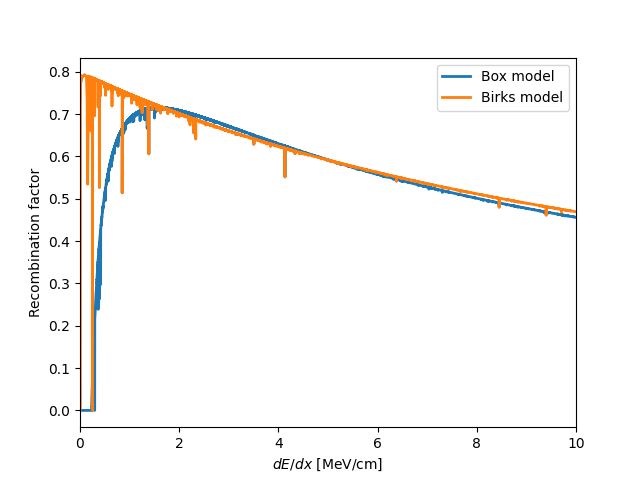

<IPython.core.display.Javascript object>


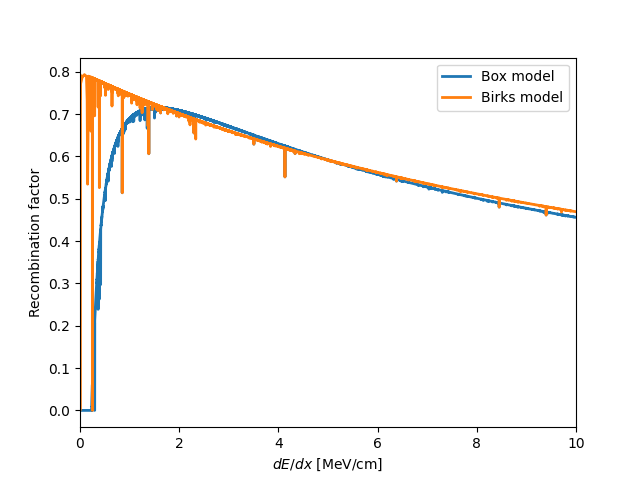

In [6]:
%matplotlib notebook

def plot_tracks(tracks_box, tracks_birks):
    fig, ax = plt.subplots(1, 1)

    recomb_birks = tracks_birks["n_electrons"] / (consts.MeVToElectrons * tracks_birks["dE"])
    recomb_box = tracks_box["n_electrons"] / (consts.MeVToElectrons * tracks_box["dE"])

    ax.plot(np.sort(tracks_box["dEdx"]), recomb_box[np.argsort(tracks_box["dEdx"])], 
            label="Box model", lw=2)
    ax.plot(np.sort(tracks_birks["dEdx"]), recomb_birks[np.argsort(tracks_birks["dEdx"])],
            label="Birks model", lw=2)
    ax.set_xlabel("$dE/dx$ [MeV/cm]")
    ax.set_ylabel("Recombination factor")
    ax.set_xlim(0,10)
    _ = ax.legend()
    
plot_tracks(tracks_box, tracks_birks)

#from structured to unstructerd
tracks_box_torch = torch_from_structured(np.copy(tracks))
tracks_birks_torch = torch_from_structured(np.copy(tracks))
quenching_ep.quench(tracks_box_torch, consts.box, tracks.dtype.names)
quenching_ep.quench(tracks_birks_torch, consts.birks, tracks.dtype.names)
plot_tracks(structered_from_torch(tracks_box_torch, tracks.dtype),
            structered_from_torch(tracks_birks_torch, tracks.dtype))

## Electron lifetime
The electrons traveling towards the anode are absorbed by impurities present in the liquid argon. The decrease follows an exponential curve $N_e^{\mathrm{anode}}/N_e=\exp(-t_{\mathrm{drift}}/e_{\mathrm{lifetime}})$.

<IPython.core.display.Javascript object>


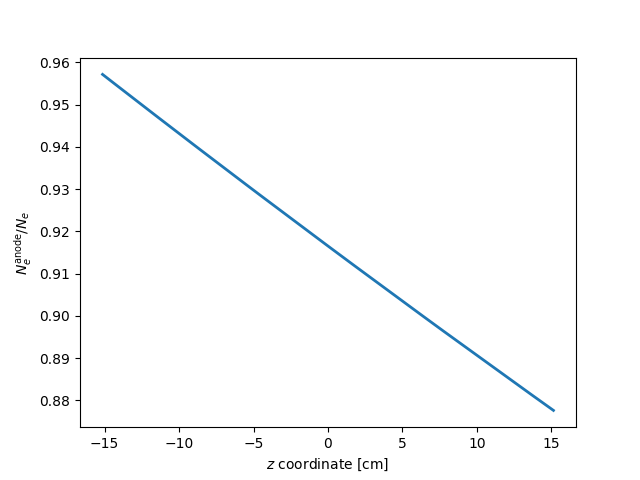

<IPython.core.display.Javascript object>


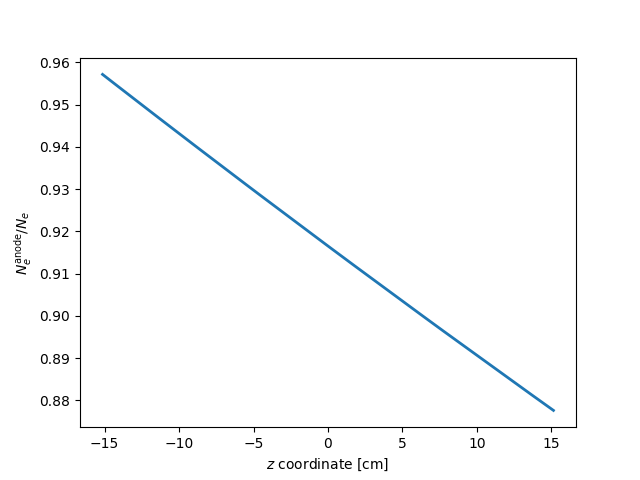

In [7]:
def plotDriftTime(tracks):
    fig, ax = plt.subplots(1, 1)
    drift_time = abs(tracks["z"] - consts.tpc_borders[0][2][0])/consts.vdrift
    ax.plot(np.sort(tracks["z"]), np.exp(-drift_time / consts.lifetime)[np.argsort(tracks['z'])], lw=2)
    ax.set_ylabel("$N_{e}^{\mathrm{anode}}/N_{e}$")
    _ = ax.set_xlabel("$z$ coordinate [cm]")
    
tracks_quenched = np.copy(tracks)
quenching.quench[blockspergrid,threadsperblock](tracks_quenched, consts.box)
tracks_drifted = np.copy(tracks_quenched)
drifting.drift[blockspergrid,threadsperblock](tracks_drifted)
plotDriftTime(tracks_drifted)

tracks_quenched_torch = torch_from_structured(np.copy(tracks))
quenching_ep.quench(tracks_quenched_torch, consts.box, tracks.dtype.names)
tracks_quenched_ep = structered_from_torch(tracks_quenched_torch, tracks.dtype)
tracks_drifted_torch = torch_from_structured(np.copy(tracks_quenched_ep))
drifting_ep.drift(tracks_drifted_torch, tracks.dtype.names)
tracks_drifted_ep = structered_from_torch(tracks_drifted_torch, tracks.dtype)
plotDriftTime(tracks_drifted_ep)

## Diffusion
The diffusion coefficients (longitudinal and transverse) are proportional to $\sqrt{2t_{\mathrm{drift}}}$ (which in turn is given by $(z_{\mathrm{start}} - z_{\mathrm{anode}})/v_{\mathrm{drift}}$).

<IPython.core.display.Javascript object>


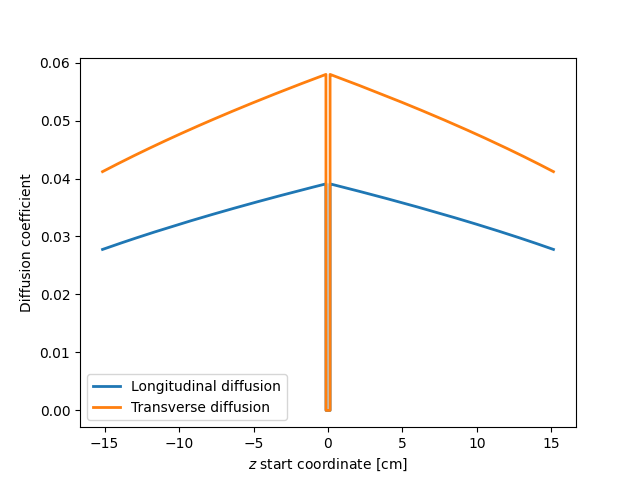

<IPython.core.display.Javascript object>


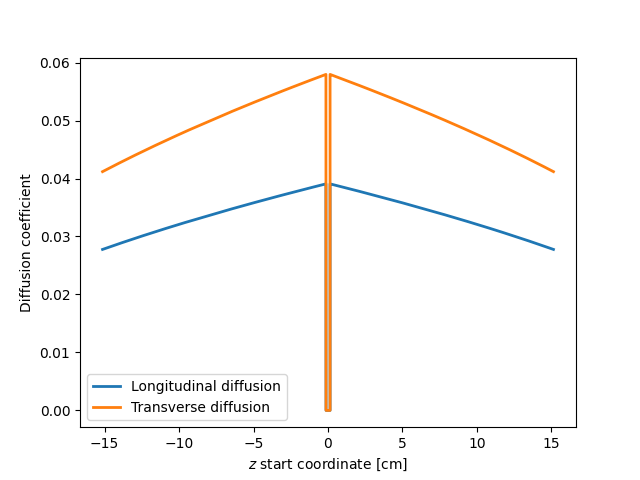

In [8]:
def plotDiffusion(tracks):
    fig, ax = plt.subplots(1, 1)
    ax.plot(np.sort(tracks["z"]), tracks["long_diff"][np.argsort(tracks["z"])], label="Longitudinal diffusion", lw=2)
    ax.plot(np.sort(tracks["z"]), tracks["tran_diff"][np.argsort(tracks["z"])], label="Transverse diffusion", lw=2)
    ax.set_xlabel("$z$ start coordinate [cm]")
    ax.set_ylabel("Diffusion coefficient")
    _ = ax.legend()

plotDiffusion(tracks_drifted)
plotDiffusion(tracks_drifted_ep)